In [1]:
!pip install meteostat geopandas swifter

     |████████████████████████████████| 972kB 5.2MB/s 
     |████████████████████████████████| 634kB 13.8MB/s 
     |████████████████████████████████| 14.8MB 297kB/s 
     |████████████████████████████████| 6.5MB 37.7MB/s 
     |████████████████████████████████| 296kB 41.7MB/s 
     |████████████████████████████████| 573kB 48.3MB/s 
     |████████████████████████████████| 102kB 10.4MB/s 
     |████████████████████████████████| 17.2MB 257kB/s 
     |████████████████████████████████| 48.5MB 98kB/s 
     |████████████████████████████████| 71kB 8.6MB/s 
     |████████████████████████████████| 81kB 9.7MB/s 
     |████████████████████████████████| 133kB 36.9MB/s 
     |████████████████████████████████| 1.3MB 34.8MB/s 
     |████████████████████████████████| 81kB 9.2MB/s 
     |████████████████████████████████| 3.2MB 38.3MB/s 
     |████████████████████████████████| 204kB 51.3MB/s 
     |████████████████████████████████| 61kB 6.8MB/s 
     |████████████████████████████████| 143kB 55.2MB/s 
  

In [2]:
# importing libraries
import pandas as pd
import matplotlib.pyplot as plt
#import descartes
# import geopandas as gpd
from shapely.geometry import Point, Polygon
import io

# Import Meteostat library and dependencies
from datetime import datetime
from meteostat import Hourly
from meteostat import Stations
import numpy as np
import swifter
import pickle

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
from google.colab import files

url="/content/gdrive/My Drive/three_trackes_with_weather.csv"
tracks_with_weather=pd.read_csv(url)

### Finding Correlation and Fitting Model

Fetching Data For Each Weather Features
- temp: temperature in degree Celcius
- dwpt: dew point temperature in degres Celcius
- rhum: relative humidity
- wdir: wind direction
- wspd: wind speed
- pres: pressure

In [6]:
sample_tracks = tracks_with_weather.dropna(subset=['temp', 'dwpt', 'rhum', 'wdir', 'wspd', 'pres']).copy()
sample_tracks.drop(['Unnamed: 0','# Timestamp', 'Type of mobile', 'Navigational status', 'Name', 'Ship type','Type of position fixing device',	'Data source type', 'tsun', 'coco', 'snow'], axis = 1, inplace = True)

In [7]:
sample_tracks.columns

Index(['MMSI', 'Latitude', 'Longitude', 'ROT', 'SOG', 'COG', 'Heading',
       'Width', 'Length', 'temp', 'dwpt', 'rhum', 'prcp', 'wdir', 'wspd',
       'wpgt', 'pres'],
      dtype='object')

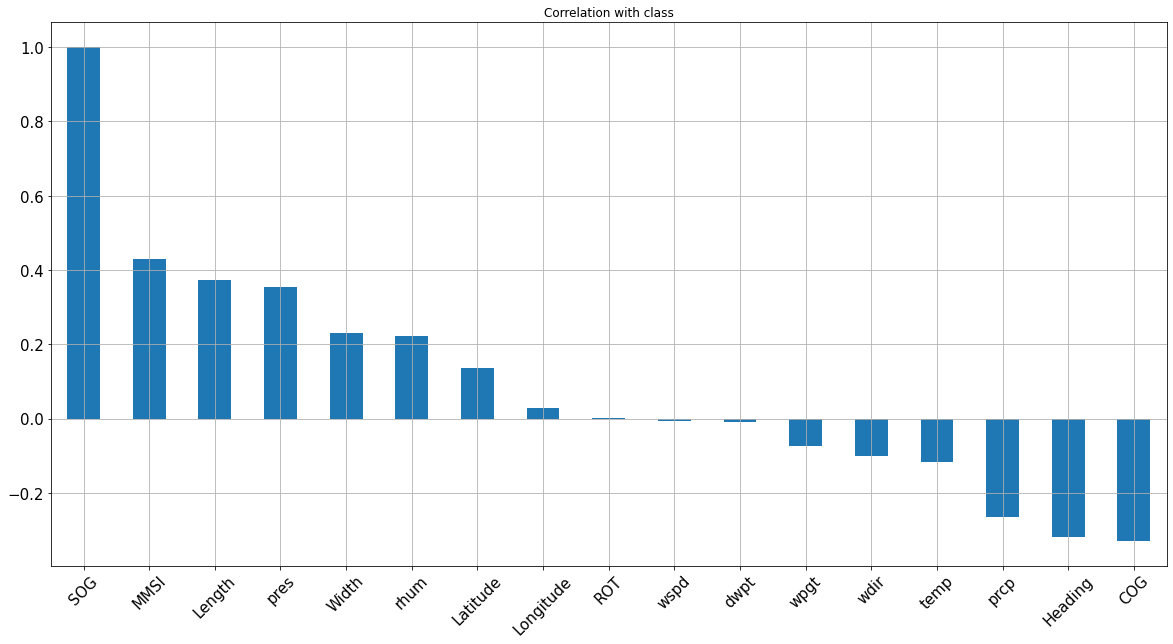

In [8]:
sample_tracks.MMSI = sample_tracks.MMSI.astype(float)
sample_tracks.corrwith(sample_tracks.SOG).sort_values(ascending=False).plot.bar(
        figsize = (20, 10), title = "Correlation with class", fontsize = 15,
        rot = 45, grid = True)

In [ ]:
sample_tracks

,MMSI,Latitude,Longitude,ROT,SOG,COG,Heading,Width,Length,temp,dwpt,rhum,prcp,wdir,wspd,wpgt,pres
0,538002777.0,56.763667,11.913167,-5.4,10.3,344.0,338.0,32.0,195.0,6.8,4.3,84.0,0.7,138.0,42.6,70.4,981.7
1,538002777.0,56.764167,11.913000,7.5,10.4,344.0,339.0,32.0,195.0,6.8,4.3,84.0,0.7,138.0,42.6,70.4,981.7
2,538002777.0,56.764333,11.912833,6.4,10.4,344.0,340.0,32.0,195.0,6.8,4.3,84.0,0.7,138.0,42.6,70.4,981.7
3,538002777.0,56.764667,11.912667,11.4,10.3,345.0,340.0,32.0,195.0,6.8,4.3,84.0,0.7,138.0,42.6,70.4,981.7
4,538002777.0,56.764833,11.912500,-5.4,10.3,345.0,341.0,32.0,195.0,6.8,4.3,84.0,0.7,138.0,42.6,70.4,981.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23321,538090512.0,55.220082,13.111102,0.0,14.8,95.5,95.0,27.0,184.0,4.6,2.9,89.0,0.0,120.0,22.2,33.3,985.2
23322,538090512.0,55.220042,13.111810,0.0,14.8,95.5,95.0,27.0,184.0,4.6,2.9,89.0,0.0,120.0,22.2,33.3,985.2
23323,538090512.0,55.220010,13.112400,0.0,14.8,95.5,95.0,27.0,184.0,4.6,2.9,89.0,0.0,120.0,22.2,33.3,985.2
23324,538090512.0,55.219963,13.113232,0.0,14.8,95.4,95.0,27.0,184.0,4.6,2.9,89.0,0.0,120.0,22.2,33.3,985.2


In [9]:
sample_tracks.iloc[10445]

MMSI         2.190760e+08
Latitude     5.457057e+01
Longitude    1.230964e+01
ROT         -1.600000e+00
SOG          1.170000e+01
COG          1.890000e+01
Heading      1.900000e+01
Width        2.200000e+01
Length       1.410000e+02
temp         3.500000e+00
dwpt         1.500000e+00
rhum         8.700000e+01
prcp         0.000000e+00
wdir         1.360000e+02
wspd         2.040000e+01
wpgt         3.330000e+01
pres         9.844000e+02
Name: 12260, dtype: float64

Separating Features And Target

In [10]:
y = sample_tracks['SOG'].copy().ravel()
y

array([10.3, 10.4, 10.4, ..., 14.8, 14.8, 14.8])

In [26]:
X = sample_tracks[['COG','Heading', 'pres', 'temp']].copy()

In [12]:
X

,COG,Heading,pres,temp,Length,MMSI
0,344.0,338.0,981.7,6.8,195.0,538002777.0
1,344.0,339.0,981.7,6.8,195.0,538002777.0
2,344.0,340.0,981.7,6.8,195.0,538002777.0
3,345.0,340.0,981.7,6.8,195.0,538002777.0
4,345.0,341.0,981.7,6.8,195.0,538002777.0
...,...,...,...,...,...,...
23321,95.5,95.0,985.2,4.6,184.0,538090512.0
23322,95.5,95.0,985.2,4.6,184.0,538090512.0
23323,95.5,95.0,985.2,4.6,184.0,538090512.0
23324,95.4,95.0,985.2,4.6,184.0,538090512.0


Data Normalization

In [27]:
from sklearn.preprocessing import StandardScaler

# X['normLat'] = StandardScaler().fit_transform(X['Latitude'].values.reshape(-1,1))
X['normCOG'] = StandardScaler().fit_transform(X['COG'].values.reshape(-1,1))
X['normHeading'] = StandardScaler().fit_transform(X['Heading'].values.reshape(-1,1))
X['normPres'] = StandardScaler().fit_transform(X['pres'].values.reshape(-1,1))
X['normTemp'] = StandardScaler().fit_transform(X['temp'].values.reshape(-1,1))
# X['normLength'] = StandardScaler().fit_transform(X['Length'].values.reshape(-1,1))
# X['normMMSI'] = StandardScaler().fit_transform(X['MMSI'].values.reshape(-1,1))

# X['normPrcp'] = StandardScaler().fit_transform(X['prcp'].values.reshape(-1,1))
# X['normRhum'] = StandardScaler().fit_transform(X['rhum'].values.reshape(-1,1))

X.drop(['Heading', 'COG', 'pres', 'temp'], axis=1, inplace=True)

Spilt Testing And Training Data 

In [28]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=4)

print('Train set:', x_train.shape, y_train.shape)
print('Test set:', x_test.shape, y_test.shape)

Train set: (15656, 4) (15656,)
Test set: (2763, 4) (2763,)


Fitting Model

In [29]:
from sklearn.svm import SVR

regressor = SVR(gamma='scale', C=100000, epsilon=1, degree=3)

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
model_save_name = 'aisclassifier.sav'
path = F'/content/gdrive/My Drive/{model_save_name}'
pickle.dump(regressor, open(path,'wb'))

In [30]:
regressor.fit(x_train, y_train)

SVR(C=100000, cache_size=200, coef0=0.0, degree=3, epsilon=1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [31]:
yhat = regressor.predict(x_test)

In [32]:
from sklearn.metrics import r2_score
print(round(r2_score(y_test, yhat),2))

0.85


In [33]:
# make df of predicted & real values
predicted_vs_real = pd.DataFrame({'Actual': y_test,
                                 'Predicted': yhat})

predicted_vs_real

,Actual,Predicted
0,13.2,12.978771
1,9.3,8.666601
2,13.0,12.605212
3,13.1,12.684059
4,11.4,11.405518
...,...,...
2758,13.6,14.545217
2759,11.4,11.411541
2760,10.9,10.752105
2761,13.8,14.067557


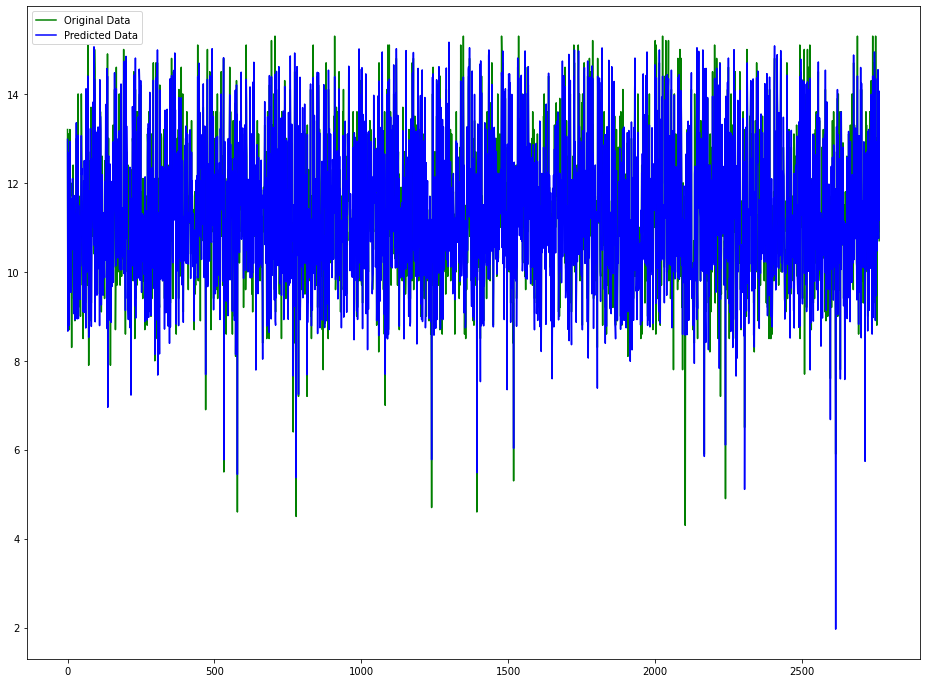

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,12))
labels = ['Original Data', 'Predicted Data']
plt.plot(y_test, color = 'green', label = 'Original Data')
plt.plot(yhat, color = 'blue', label = 'Predicted Data')
plt.legend(labels)
plt.show()

In [44]:
import json
predictedData = [y_test.tolist(), yhat.tolist()]
# predictedData
k = json.dumps(predictedData)


[[13.2, 9.3, 13.0, 13.1, 11.4, 9.6, 8.7, 11.7, 13.2, 10.2, 10.9, 10.7, 9.9, 11.4, 8.3, 11.1, 12.0, 11.7, 12.1, 12.4, 11.1, 9.4, 9.7, 11.7, 10.0, 8.9, 10.9, 10.7, 9.7, 10.9, 13.0, 10.6, 11.7, 9.8, 9.3, 10.0, 14.0, 9.2, 11.1, 9.8, 11.7, 10.5, 9.7, 9.9, 9.0, 10.9, 13.1, 14.0, 13.2, 12.0, 10.6, 9.7, 11.3, 8.5, 10.5, 11.6, 9.8, 11.5, 11.1, 10.9, 12.2, 9.3, 9.4, 13.2, 11.6, 9.9, 11.9, 9.9, 9.7, 15.1, 13.9, 10.0, 7.9, 9.1, 12.5, 10.7, 12.2, 11.6, 12.7, 8.9, 13.7, 9.3, 10.9, 11.5, 10.8, 11.6, 12.9, 11.6, 10.9, 11.6, 14.7, 10.4, 15.0, 14.5, 8.9, 13.1, 11.6, 11.6, 12.6, 12.0, 9.8, 11.7, 10.9, 13.1, 12.7, 11.7, 11.0, 10.9, 11.3, 9.5, 14.0, 10.8, 13.6, 12.4, 11.1, 9.1, 10.5, 10.3, 12.6, 11.6, 10.0, 10.0, 9.9, 11.2, 11.0, 10.4, 9.4, 12.5, 11.2, 12.0, 13.1, 13.6, 11.8, 10.6, 14.4, 9.5, 14.9, 8.4, 11.4, 13.0, 13.0, 10.9, 9.6, 11.2, 11.2, 12.4, 7.9, 11.2, 9.3, 11.7, 10.9, 10.2, 9.9, 10.8, 11.9, 13.3, 10.1, 11.1, 12.5, 12.3, 14.1, 11.3, 12.4, 8.7, 9.8, 10.5, 14.6, 11.2, 9.7, 11.1, 10.9, 12.9, 12.5, 11.

In [45]:
# # Save the DataFrame to a file on the Colab backend.
# with open('df.json', 'w') as f:
#   f.write(k)
# files.download('df.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
# round off predicted values
import numpy as np
yhat = np.round(yhat,1)
yhat[:5]

array([13. ,  8.7, 12.6, 12.7, 11.4])

In [48]:
# make df of predicted & real values
predicted_vs_real = pd.DataFrame({'Actual': y_test,
                                 'Predicted': yhat})

predicted_vs_real

,Actual,Predicted
0,13.2,13.0
1,9.3,8.7
2,13.0,12.6
3,13.1,12.7
4,11.4,11.4
...,...,...
2758,13.6,14.5
2759,11.4,11.4
2760,10.9,10.8
2761,13.8,14.1


In [49]:
predicted_vs_real['difference'] = predicted_vs_real['Actual'] - predicted_vs_real['Predicted']
predicted_vs_real

,Actual,Predicted,difference
0,13.2,13.0,0.2
1,9.3,8.7,0.6
2,13.0,12.6,0.4
3,13.1,12.7,0.4
4,11.4,11.4,0.0
...,...,...,...
2758,13.6,14.5,-0.9
2759,11.4,11.4,0.0
2760,10.9,10.8,0.1
2761,13.8,14.1,-0.3
